In [1]:
import os, time
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from PIL import Image
from tqdm import tqdm
import pandas as pd
from scipy.optimize import brentq
from scipy.stats import binom

In [2]:
# The classification algorithm
def find_ellipse(filename, plot):
    img_full = cv.imread(filename, cv.IMREAD_COLOR)

    cropRows = [-img_full.shape[0]//3, -img_full.shape[0]//6]
    cropCols = [-img_full.shape[1]//5, -img_full.shape[1]//15]

    img = img_full[cropRows[0]:cropRows[1],cropCols[0]:cropCols[1],:]


    # Check if image is loaded fine
    if img is None:
        print ('Error opening image!')
        print ('Usage: hough_circle.py [image_name -- default ' + default_file + '] \n')


    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    gray = 255-gray

    rows = gray.shape[0]

    contours,hierarchy = cv.findContours(gray,2,1)
    contours_passed = []
    fit_ellipses = []
    areas = []
    area_constraints = [250,1500]
    for i in contours:
        area = cv.contourArea(i) 
        if(area >= area_constraints[0] and area <= area_constraints[1]):
            contours_passed += [i]
            curr_ell = cv.fitEllipse(i)
            fit_ellipses += [curr_ell]
            areas += [area]
    contours_passed, areas = np.array(contours_passed), np.array(areas)
    analytic_areas = np.array([ell[1][0]*ell[1][1]*np.pi/4.0 for ell in fit_ellipses])
    if areas.shape[0] == 0:
        vote = -1
    else:
        idx_best = np.argmin( np.abs(analytic_areas - areas)/areas )
        ell_best = fit_ellipses[idx_best]
        decision_boundary = int(img.shape[0]/1.5)
        vote = fit_ellipses[idx_best][0][1] >= decision_boundary
        if plot:
            cv.line(img, (0,decision_boundary), (img.shape[1]-1,decision_boundary), (255,0,0), 2)
            cv.ellipse(img, fit_ellipses[idx_best], (0,255,0), -1)

    if plot:
        img_full[cropRows[0]:cropRows[1],cropCols[0]:cropCols[1],:] = img

        plt.figure(figsize=(15,15))
        plt.imshow(img_full)
        plt.axis('off');
    
    return vote

In [3]:
# Process .tif images into .png
base_path = "/Users/angelopoulos/Code/working/ballots/raw/A22_BallotImages"
new_path = "/Users/angelopoulos/Code/working/ballots/proc/"
ballot_dirnames = []
ballot_filenames = []
os.makedirs(new_path, exist_ok = True)
counter = 1
for dirpath, dirnames, filenames in os.walk(base_path):
    for filename in filenames:
        if '.tif' in filename:
            ballot_dirnames += [dirpath,]
            ballot_filenames += [filename,]

for i in tqdm(range(len(ballot_filenames))):
    if not os.path.exists(new_path + str(counter) + ".png"):
        img_full = cv.imread(ballot_dirnames[i] + "/" + ballot_filenames[i], cv.IMREAD_COLOR)
        cv.imwrite(new_path + str(counter) + ".png", img_full)
    counter += 1

100%|█████████████████████████████████| 78771/78771 [00:00<00:00, 356537.63it/s]


In [4]:
cal_label_csv = pd.read_csv('labels.csv')
cal_labeled_image_filenames = [new_path + cal_label_csv['image'][i].split("/")[3] for i in range(len(cal_label_csv))]
cal_labels = -np.ones((len(cal_label_csv,)))
cal_labels[cal_label_csv['choice'] == "Matt Haney"] = 1
cal_labels[cal_label_csv['choice'] == "David Campos"] = 0

cal_preds = np.array([find_ellipse(fname, plot=False) for fname in cal_labeled_image_filenames])

/var/folders/nf/9jh22yw56mj181378_s3p7vr0000gn/T/ipykernel_46519/2661563666.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  contours_passed, areas = np.array(contours_passed), np.array(areas)


In [5]:
clean_cal_preds = cal_preds[(cal_labels >= 0) & (cal_preds >= 0)]
clean_cal_labels = cal_labels[(cal_labels >= 0) & (cal_preds >= 0)]
acc = (cal_preds[(cal_labels >= 0) & (cal_preds >= 0)] == cal_labels[(cal_labels >= 0) & (cal_preds >= 0)]).mean()

In [6]:
# Get bounds on confusion matrix for model-assisted inference
delta_0 = 0.05
delta_1 = 0.05
idx_f0 = clean_cal_preds == 0
idx_f1 = clean_cal_preds == 1
n_f0 = idx_f0.sum()
n_f1 = idx_f1.sum()
def invert_for_lb_0(r): return binom.cdf(n_f0-clean_cal_labels[idx_f0].sum(),n_f0,r)-(1-delta_0/2)
def invert_for_lb_1(r): return binom.cdf(clean_cal_labels[idx_f1].sum(),n_f1,r)-(1-delta_1/2)
def invert_for_ub_0(r): return binom.cdf(n_f0-clean_cal_labels[idx_f0].sum(),n_f0,r)-(delta_0/2)
def invert_for_ub_1(r): return binom.cdf(clean_cal_labels[idx_f1].sum(),n_f1,r)-(delta_1/2)

c0_lb = brentq(invert_for_lb_0,0,1) if n_f0-clean_cal_labels[idx_f0].sum() < n_f0 else delta_0**(1/n_f0)
c0_ub = brentq(invert_for_ub_0,0,1)

c1_lb = brentq(invert_for_lb_1,0,1) if clean_cal_labels[idx_f1].sum() < n_f1 else delta_1**(1/n_f1)
c1_ub = brentq(invert_for_ub_1,0,1) if clean_cal_labels[idx_f1].sum() < n_f1 else 1.0

print(c0_lb,c1_lb)
print(c0_ub,c1_ub)

0.9600843912245248 0.995300805058436
0.989421971928017 1.0


In [11]:
# Do the counting
base_path = "/Users/angelopoulos/Code/working/ballots/proc/"
plot = False
ballot_filenames = []
print_rate = 100
for dirpath, dirnames, filenames in os.walk(base_path):
    for filename in filenames:
        if '.png' in filename:
            ballot_filenames += [dirpath + "/" + filename, ]
# Count the model-assisted votes
vote_counts = np.array([0,0,0])
for i in range(len(ballot_filenames)):
    ballot_filename = ballot_filenames[i]
    if ballot_filename in cal_labeled_image_filenames: # Don't count the ones we already labeled
        continue
    else:
        vote = find_ellipse(ballot_filename, plot=plot)
        if vote >= 0:
            vote_counts[int(vote)] += 1
        else:
            vote_counts[2] += 1
        if i % print_rate == 0:
            print(f"Vote Count ({float(i)/float(len(ballot_filenames))*100:.2f}% counted): Haney {vote_counts[1]} ({vote_counts[1]/(vote_counts[0]+vote_counts[1])*100:.2f}%), Campos {vote_counts[0]} ({100-vote_counts[1]/(vote_counts[0]+vote_counts[1])*100:.2f}%), Thrown Out {vote_counts[2]} ({vote_counts[2]/vote_counts.sum()*100:.2f}%)", end="\r")

print("\n")
print(f"Final Count ({float(i)/float(len(ballot_filenames))*100:.2f}% counted): Haney {vote_counts[1]} ({vote_counts[1]/(vote_counts[0]+vote_counts[1])*100:.2f}%), Campos {vote_counts[0]} ({100-vote_counts[1]/(vote_counts[0]+vote_counts[1])*100:.2f}%), Thrown Out {vote_counts[2]} ({vote_counts[2]/vote_counts.sum()*100:.2f}%)", end="\r")

/var/folders/nf/9jh22yw56mj181378_s3p7vr0000gn/T/ipykernel_46519/2661563666.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  contours_passed, areas = np.array(contours_passed), np.array(areas)


Vote Count (99.91% counted): Haney 47814 (61.24%), Campos 30267 (38.76%), Thrown Out 620 (0.79%)



In [8]:
# Run model-assisted inference
vote_counts = np.array([30292, 47858, 621])
p1 = vote_counts[1]/(vote_counts[0]+vote_counts[1])
mu_lo_unlabeled = p1*c1_lb + (1-p1)*(1-c0_ub)
mu_hi_unlabeled = p1*c1_ub + (1-p1)*(1-c0_lb)
mu_lo = (mu_lo_unlabeled * (vote_counts[0]+vote_counts[1]) + cal_labels.sum())/(vote_counts[0]+vote_counts[1]+cal_labels.shape[0])
mu_hi = (mu_hi_unlabeled * (vote_counts[0]+vote_counts[1]) + cal_labels.sum())/(vote_counts[0]+vote_counts[1]+cal_labels.shape[0])
print(f"The confidence interval for Matt Haney's percentage of the vote is: [{mu_lo*100:.2f}%,{mu_hi*100:.2f}%]")

The confidence interval for Matt Haney's percentage of the vote is: [61.35%,62.75%]


In [9]:
# Point estimate with no correction
mu_baseline = (mu_lo_unlabeled * (vote_counts[0]+vote_counts[1]) + cal_preds.sum())/(vote_counts[0]+vote_counts[1]+cal_preds.shape[0])
print(f"The uncorrected point estimate on the imputed labels is {mu_baseline*100:.2f}%")

The uncorrected point estimate on the imputed labels is 61.34%


/var/folders/nf/9jh22yw56mj181378_s3p7vr0000gn/T/ipykernel_46519/2661563666.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  contours_passed, areas = np.array(contours_passed), np.array(areas)


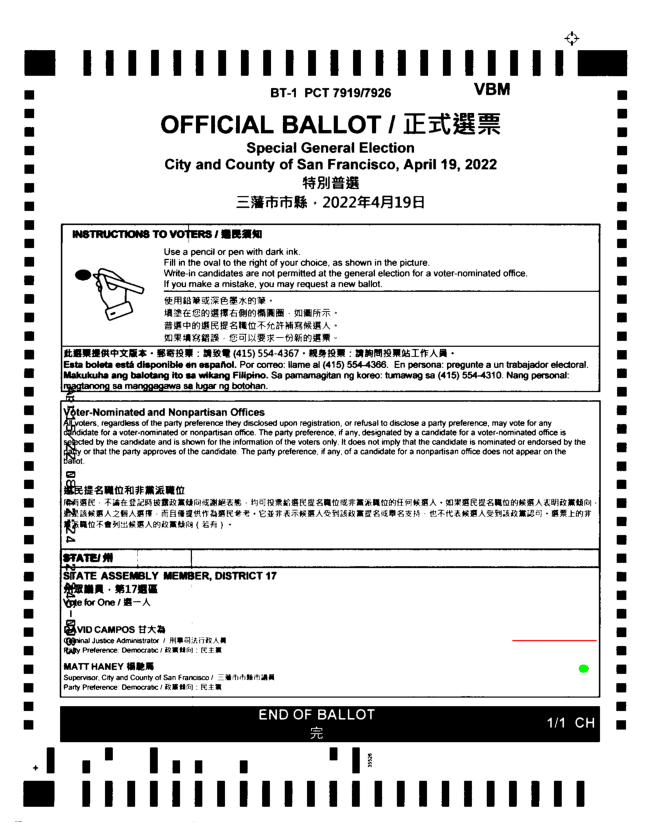

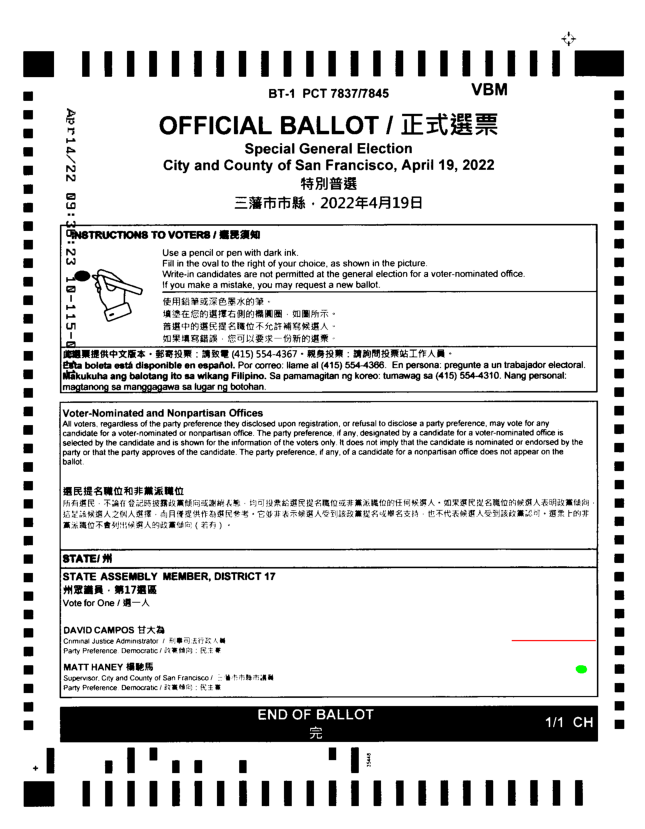

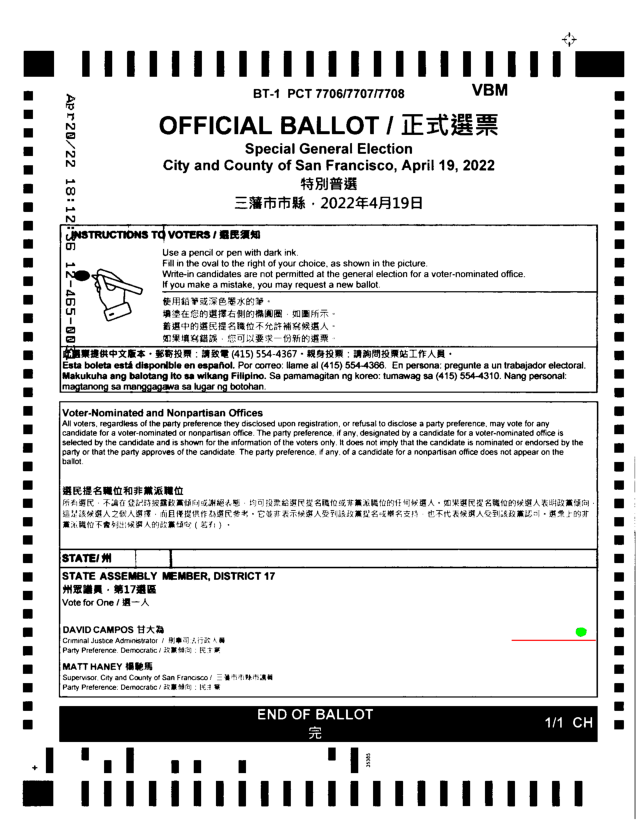

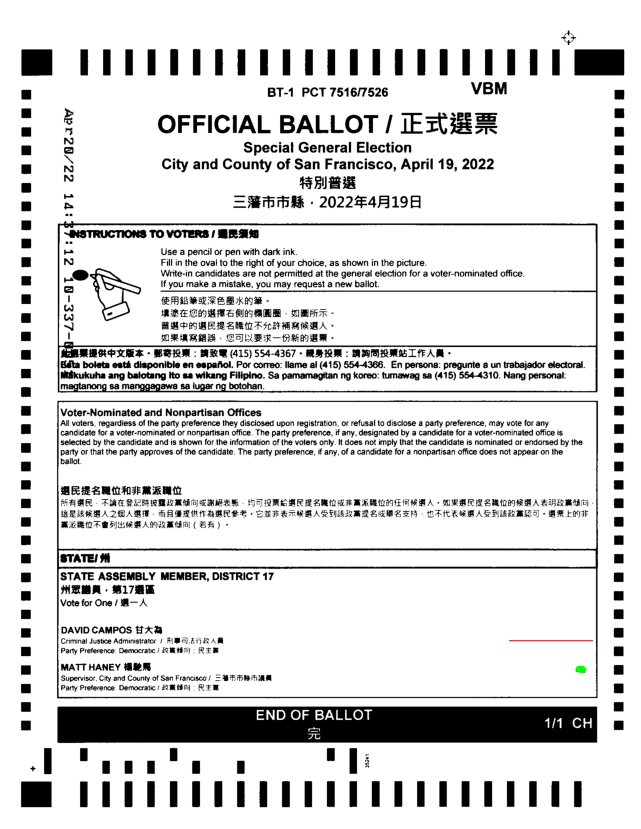

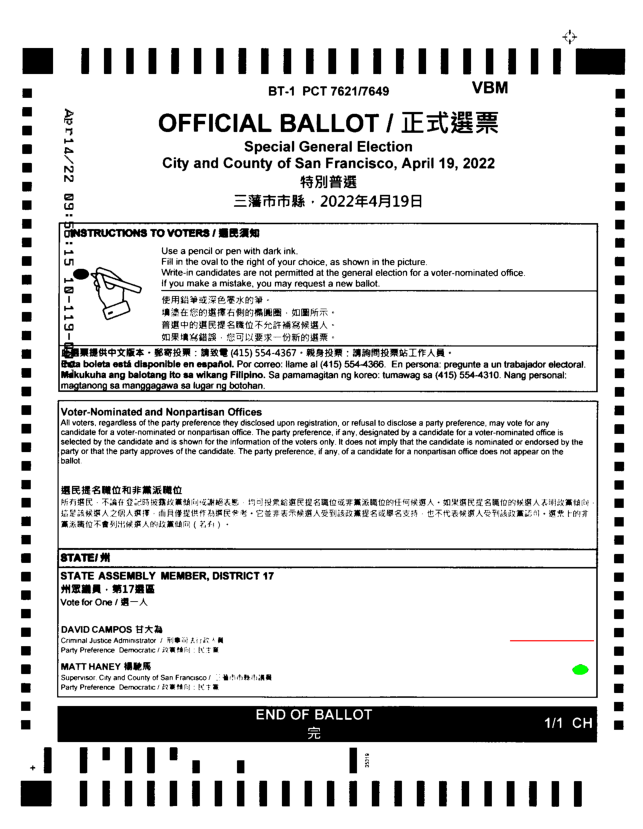

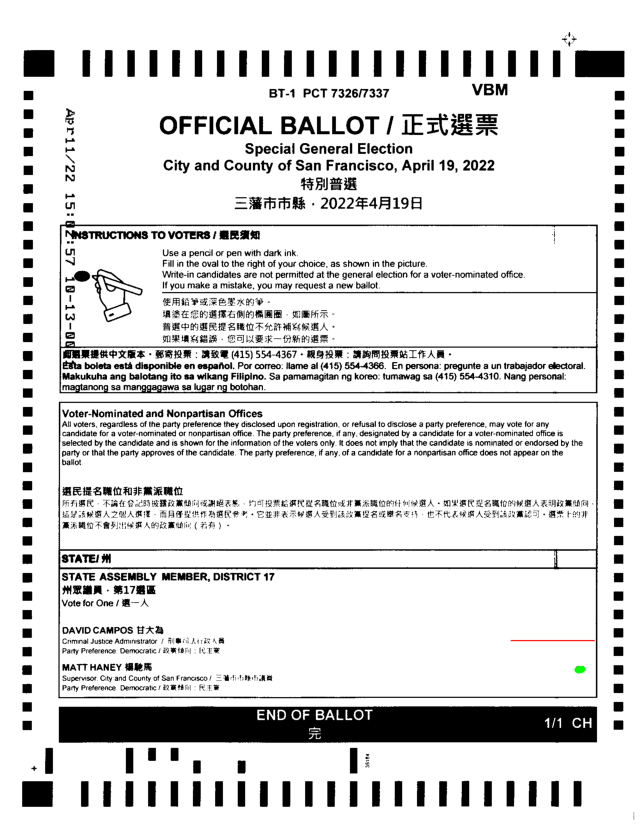

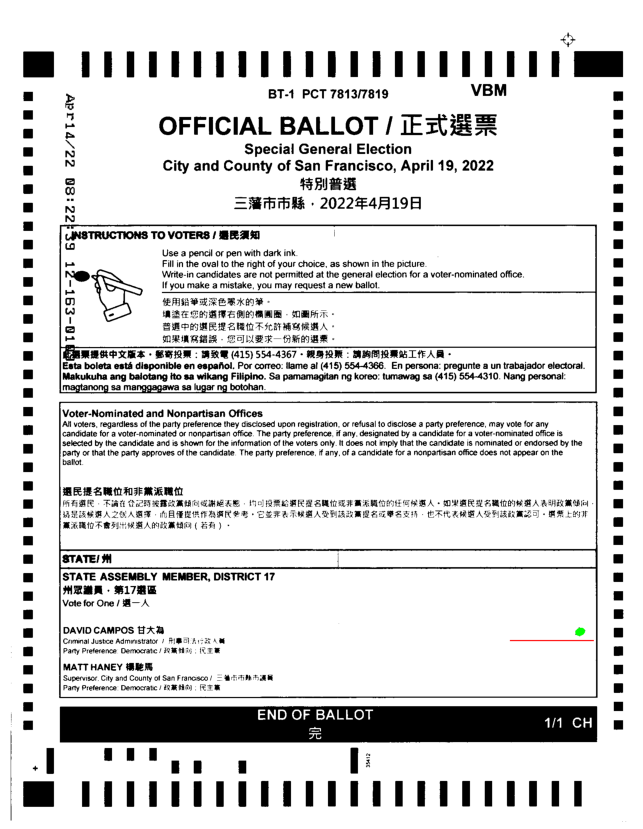

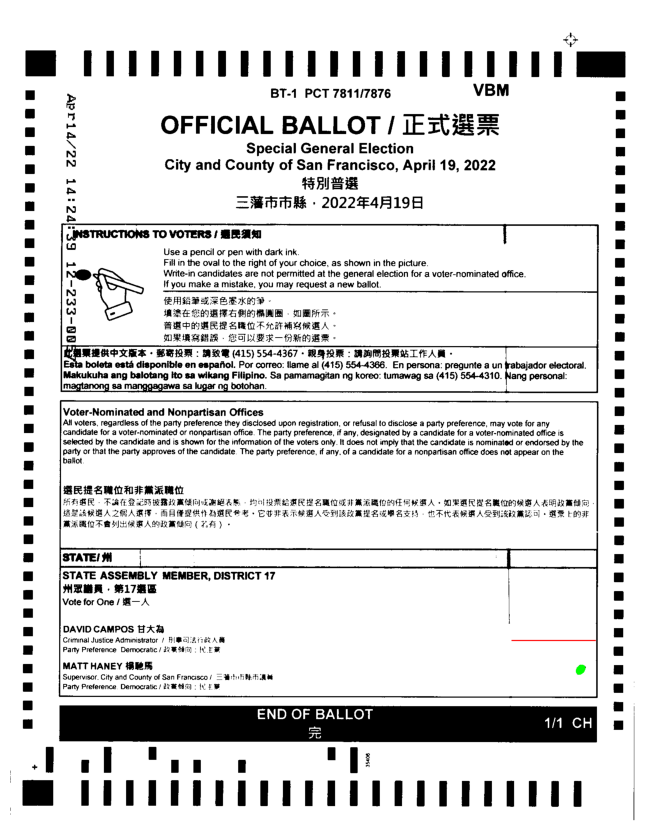

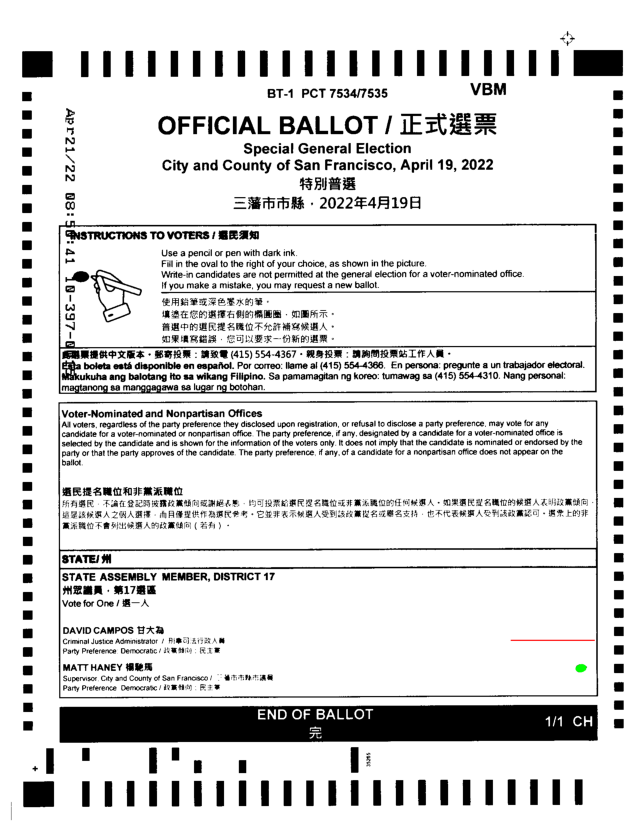

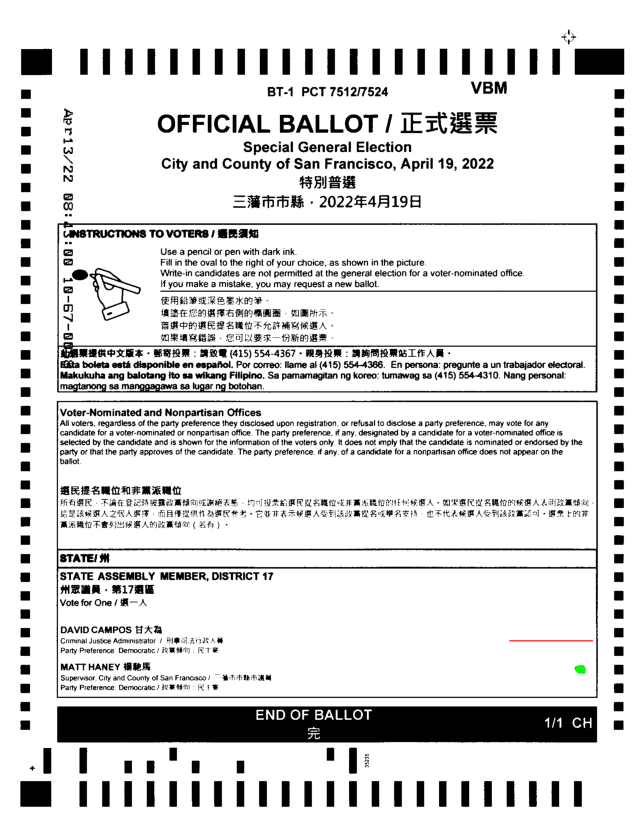

In [10]:
# Visualize data
base_path = "/Users/angelopoulos/Code/working/ballots/proc/"
ballot_filenames = []
for dirpath, dirnames, filenames in os.walk(base_path):
    for filename in filenames:
        if '.png' in filename:
            ballot_filenames += [dirpath + "/" + filename, ]
ballot_filenames = np.array(ballot_filenames)
ballot_filenames = np.random.choice(ballot_filenames, 10)
[find_ellipse(ballot_filename, plot=True) for ballot_filename in ballot_filenames];